In [1]:

import os, sys, math, json
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt



sys.path.append('/home/gamerio/Documents/dl/mice-representation/src')

from pipeline.mouse_transforms import mouse_transform

from pipeline.transforms import UnNormalize
from pipeline.mouse_csf import load_or_fit_params

IMAGE_PATH = '/home/gamerio/Desktop/output.png'  
CSF_JSON = '/home/gamerio/Documents/dl/mice-representation/cache/mouse_csf_params28.json'
os.makedirs(os.path.dirname(CSF_JSON), exist_ok=True)


np.random.seed(0)
torch.manual_seed(0)

SKIP_CSF_FIT = True

IMG_SIZE = 224


In [2]:

if SKIP_CSF_FIT:
    with open(CSF_JSON, 'r') as f:
        params = json.load(f)
    blur_sig, noise_std = params['blur_sigma'], params['noise_std']
else:
    blur_sig, noise_std = load_or_fit_params(CSF_JSON)

print(f'CSF params :blur_sigma={blur_sig:.3f}, noise_std={noise_std:.3f}')

CSF params :blur_sigma=1.000, noise_std=0.255


In [3]:
noise_rng = torch.Generator().manual_seed(1)# Generators keep motion and noise reproducible
affine_rng = torch.Generator().manual_seed(2)

tfm = mouse_transform(
    img_size=224,
    img_scale_fact=1,
    roll_deg=0.0,
    translate=(0, 0),
    blur_sig=blur_sig,
    blur_ker=11,
    noise_std=noise_std,
    normalize='imagenet',
    apply_motion=True,
    apply_csf=True,
    apply_warp=False,
    noise_rng=noise_rng,
    affine_rng=affine_rng,
    to_gray=True,
    gray_keep_channels=True,
)

unnorm = UnNormalize('imagenet')

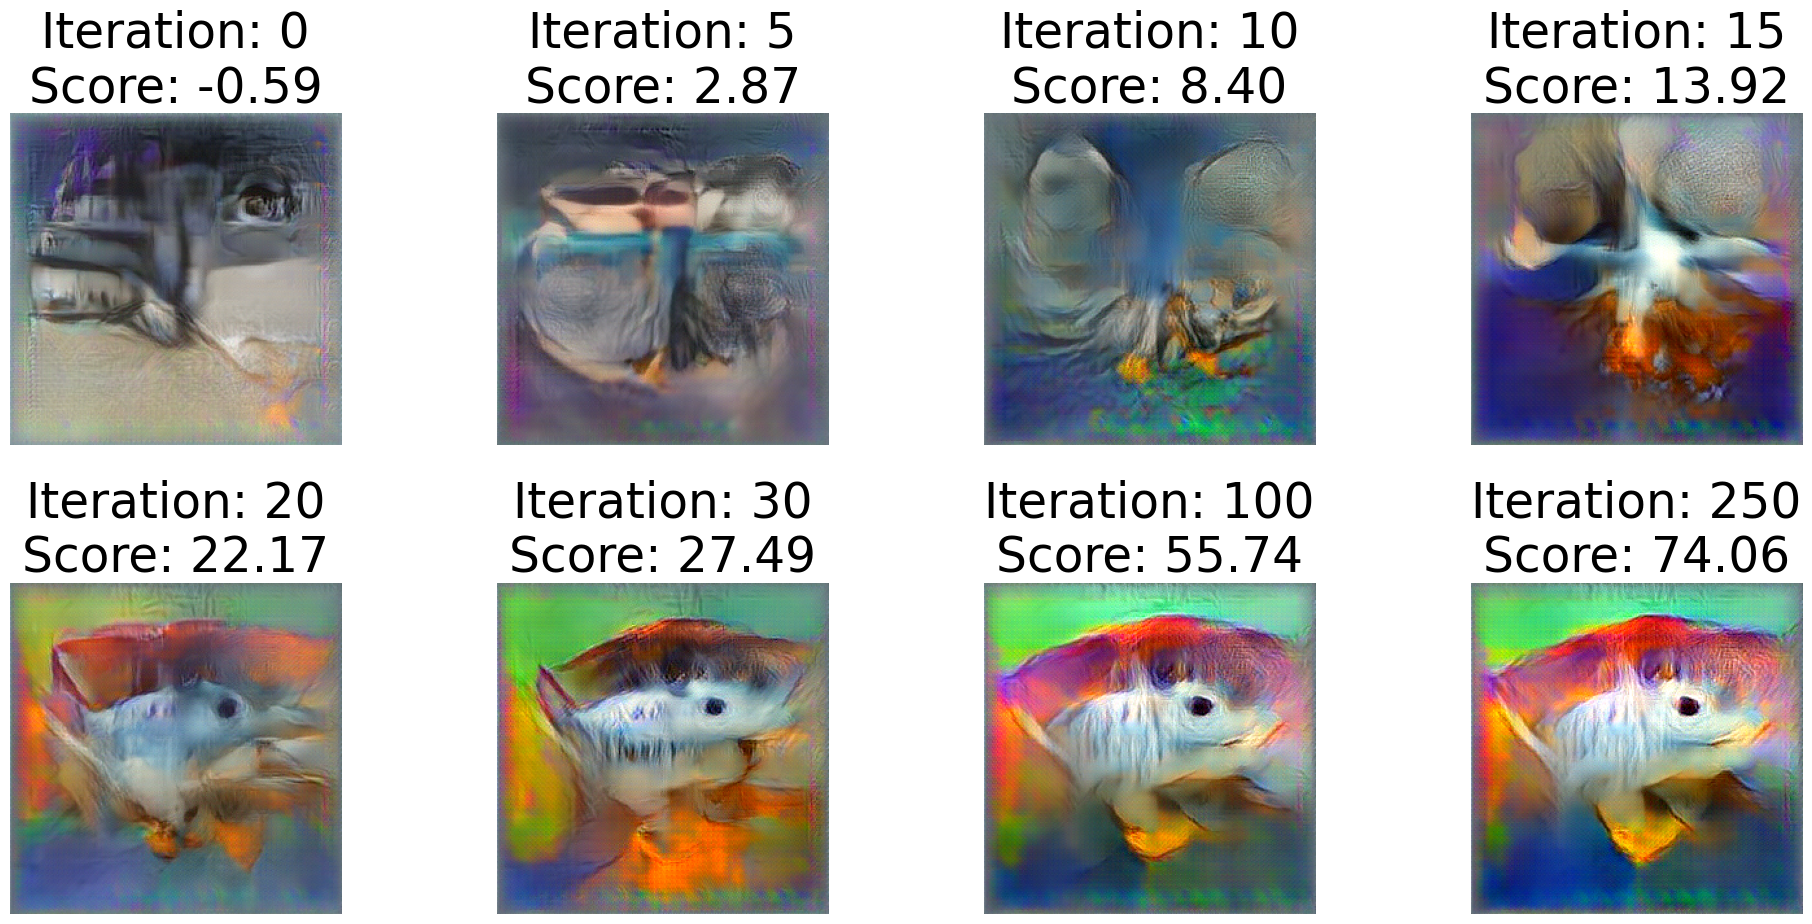

In [4]:

assert os.path.isfile(IMAGE_PATH), f'Image not found: {IMAGE_PATH}'
img_pil = Image.open(IMAGE_PATH).convert('RGB')
img_pil

In [5]:

out = tfm(img_pil)

# The pipeline returns a dict after the affine step; extract the tensor
if isinstance(out, dict):
    img_t = out['imgs']
    affine_params = out.get('affine', None)  # (angle, translations, scale, shear)
else:
    img_t = out
    affine_params = None
disp = unnorm(out if isinstance(out, dict) else img_t)
disp_t = disp['imgs'] if isinstance(disp, dict) else disp
disp_t = disp_t.detach().cpu().clamp(0, 1)
disp_np = disp_t.permute(1, 2, 0).numpy()

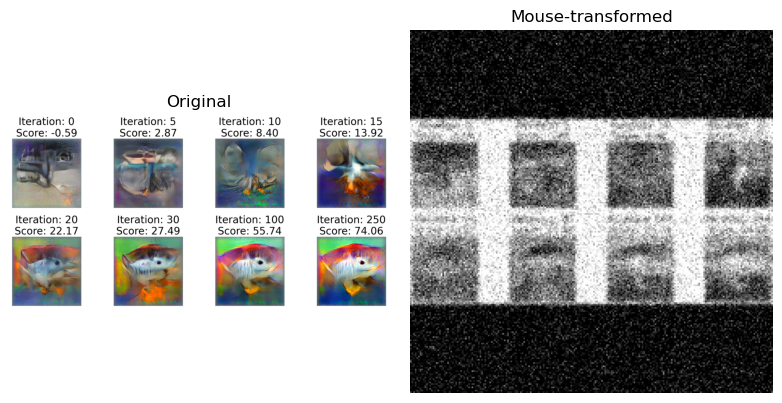

Affine params:
  angle=0.00°, translate(pixels)=(0, 0), scale=1.000, shear=(0.0, 0.0)


In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_pil)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(disp_np)
ax[1].set_title('Mouse-transformed')
ax[1].axis('off')

plt.tight_layout()
plt.show()

if affine_params is not None:
    angle, translations, scale, shear = affine_params
    print('Affine params:')
    print(f'  angle={angle:.2f}°, translate(pixels)={translations}, scale={scale:.3f}, shear={shear}')

In [8]:
# Cell — Imports for CSF plotting
import numpy as np
import matplotlib.pyplot as plt

from pipeline.mouse_params import MOUSE_CSF_TARGET, CONTRAST_SWEEP, THRESH_CRITERION, PATCH_SIZE
from pipeline.mouse_csf import _simulate_detection, _estimate_threshold
import pipeline.mouse_csf as mouse_csf  

mouse_csf.N_SAMPLES_PER_CLASS = 5000  


SIM_IMG_SIZE = 224
mouse_csf.PATCH_SIZE = 28

size = (SIM_IMG_SIZE, SIM_IMG_SIZE)

SF_LIST = sorted(MOUSE_CSF_TARGET.keys())
curves = {}         # sf -> (contrasts, acc)
thresholds = {}     # sf -> threshold

for sf in SF_LIST:
    contrasts, acc = _simulate_detection(size, sf,blur_sig, noise_std , CONTRAST_SWEEP)#
    thr = _estimate_threshold(contrasts, acc, THRESH_CRITERION)
    curves[sf] = (contrasts, acc)
    thresholds[sf] = thr

print('Done. Computed psychometric curves and thresholds for', len(SF_LIST), 'spatial frequencies.')

Done. Computed psychometric curves and thresholds for 6 spatial frequencies.


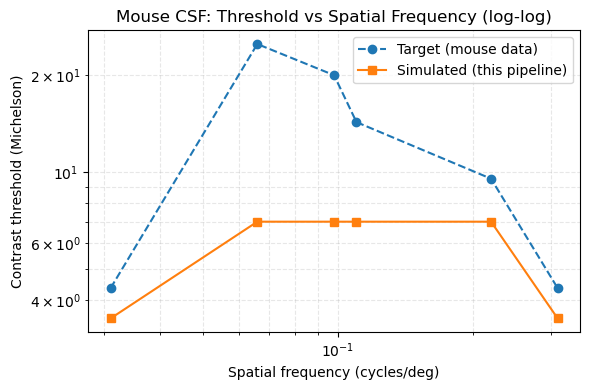

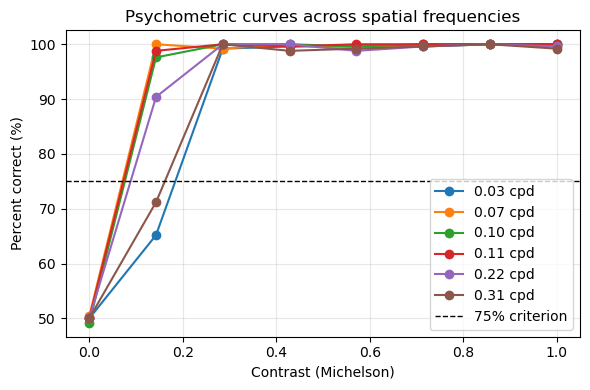

In [9]:
# Cell — Plot CSF: spatial frequency vs contrast threshold (log-log scale)
import numpy as np

sf = np.array(SF_LIST)
thr_sim = np.array([thresholds[s] for s in SF_LIST])
thr_target = np.array([MOUSE_CSF_TARGET[s] for s in SF_LIST])

plt.figure(figsize=(6,4))
plt.loglog(sf, 1/thr_target, 'o--', label='Target (mouse data)')
plt.loglog(sf, 1/thr_sim, 's-', label='Simulated (this pipeline)')
plt.xlabel('Spatial frequency (cycles/deg)')
plt.ylabel('Contrast threshold (Michelson)')
plt.title('Mouse CSF: Threshold vs Spatial Frequency (log-log)')
plt.grid(True, which='both', ls='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

# Cell — Plot psychometric functions (contrast vs % correct) for selected SFs
SFS_TO_PLOT = [x for x in [0.031,0.066,0.098,0.11,0.22,0.31] if x in curves]  # choose any subset you like

plt.figure(figsize=(6,4))
for sf in SFS_TO_PLOT:
    
    c, a = curves[sf]

    plt.plot(c, 100*a, '-o', label=f'{sf:.2f} cpd')
plt.axhline(THRESH_CRITERION*100, color='k', ls='--', lw=1, label=f'{int(THRESH_CRITERION*100)}% criterion')
plt.xlabel('Contrast (Michelson)')
plt.ylabel('Percent correct (%)')
plt.title('Psychometric curves across spatial frequencies')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

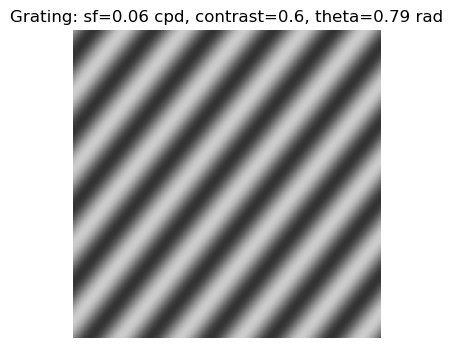

In [9]:
# Example grating using _make_grating
import sys, math
import torch
import matplotlib.pyplot as plt

# Ensure project src is importable
sys.path.append('/home/gamerio/Documents/dl/mice-representation/src')

from pipeline.mouse_csf import _make_grating  # private helper used by CSF code

# Parameters
img_size = 224

sf_cpd   = 0.06
     # spatial frequency (cycles/deg), e.g., 0.06, 0.16, 0.33
contrast = 0.6      # Michelson contrast in [0,1]
phase    = 0.0      # radians
theta    = math.pi/4  # orientation in radians (e.g., 0, pi/4, pi/2)

# Generate and display
g = _make_grating((img_size, img_size), sf_cpd, contrast, phase, theta)  # HxW tensor in [0,1]

plt.figure(figsize=(4,4))
plt.imshow(g.cpu().numpy(), cmap='gray', vmin=0.0, vmax=1.0)
plt.title(f'Grating: sf={sf_cpd} cpd, contrast={contrast}, theta={theta:.2f} rad')
plt.axis('off')
plt.show()
